In [1]:
%reset -f

import pandas as pd
import numpy as np
import math as mt
import matplotlib.pyplot as plt

# Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model

# SkLearn
import sklearn.preprocessing as SklPreProcessing
import sklearn.metrics as SklMetrics

# Other
from datetime import datetime

%matplotlib inline

Using TensorFlow backend.


In [2]:
def conversion(inData, outData, inNames, outName='Y', n_in=1):
    n_vars = 1 if (type(inData) is list) or (len(inData.shape) == 1) else inData.shape[1]
    
    dfInput = pd.DataFrame(inData)
    dfOutput = pd.DataFrame(outData)
    
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(dfInput.shift(i))
        cols.append(dfOutput.shift(i))
        names += [('%s(t-%d)' % (inNames[j], i)) for j in range(n_vars)]
        names += [('%s(t-%d)' % (outName, i))]
    
    cols.append(dfInput)
    cols.append(dfOutput)
    names += [('%s(t)' % inNames[j]) for j in range(n_vars)]
    names += [('%s(t)' % outName)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows containing NaN values
    agg.dropna(inplace=True)
    return agg

In [3]:
def plotFeatures(featureData, featureNames):
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    
    featureCount = len(featureNames)
    
    for i in range(featureCount):
        currAx = fig.add_subplot(featureCount, 1, i + 1)
        currAx.plot(featureData[:, i])
        currAx.set_title(featureNames[i])
        
    plt.show()    

In [4]:
# Load EEG data
eegDataRaw = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', skip_header=1)
eegHeader = np.genfromtxt('EEGEyeState.arff.csv', delimiter=',', max_rows=1, dtype=str)

eegInData = eegDataRaw[:, 0:14]
eegOutData = eegDataRaw[:, 14]

# eegInNames = eegHeader[0:14]
# eegOutName = eegHeader[14]

# data = conversion(eegInData, eegOutData, eegInNames, eegOutName, 1)

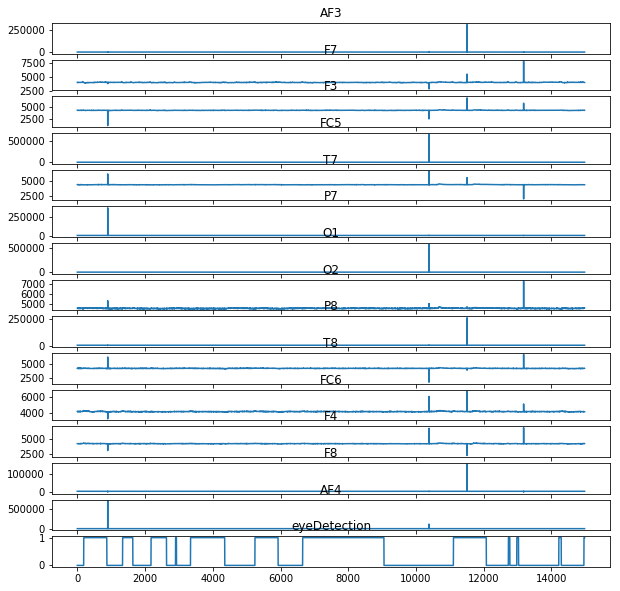

In [5]:
plotFeatures(eegDataRaw, eegHeader)

In [6]:
outLierIndexes = set()
upperLimit = 5000

featureCount = len(eegHeader)

for x in range(featureCount):
    outLiers = np.where(eegDataRaw[:, x] > upperLimit)[0]
    if len(outLiers) > 0:
        for i in xrange(len(outLiers)):
            outLierIndexes.add(outLiers[i])

outLierIndexes = list(outLierIndexes)
outLierIndexes.sort()
print 'Extreme outliers\nTotal:   ', len(outLierIndexes), \
    '\nIndexes: ', outLierIndexes

eegDataNoOutLiers = np.delete(eegDataRaw, outLierIndexes, 0)

Extreme outliers
Total:    4 
Indexes:  [898, 10386, 11509, 13179]


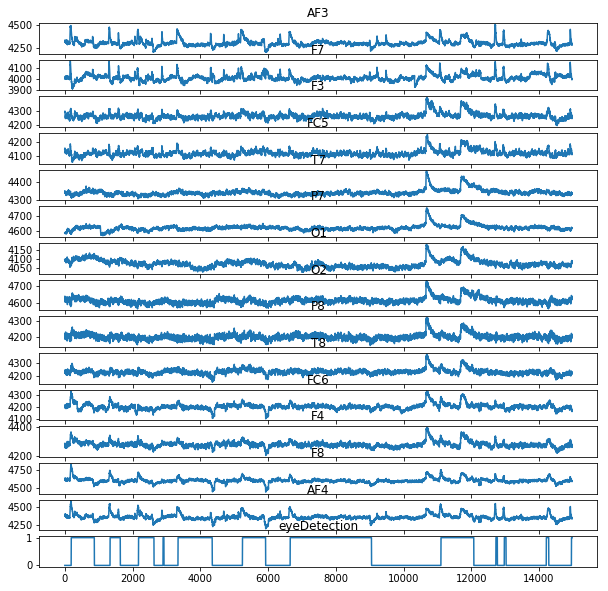

In [7]:
plotFeatures(eegDataNoOutLiers, eegHeader)

In [30]:
# normalize features
scaler = SklPreProcessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(eegDataNoOutLiers)

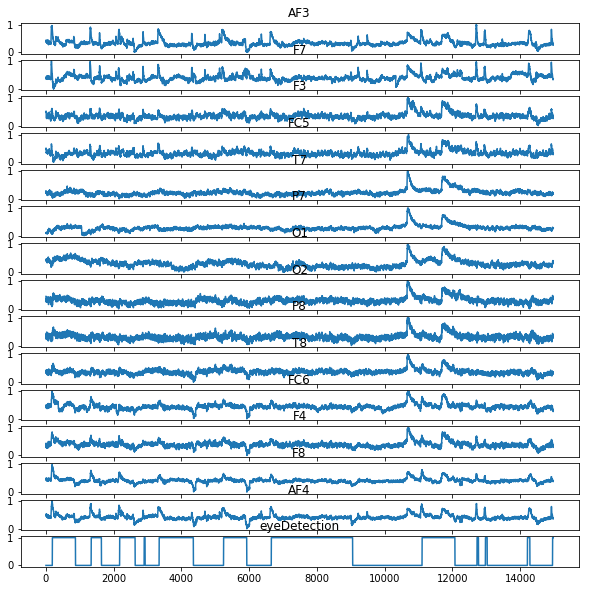

In [31]:
plotFeatures(scaled, eegHeader)

## Start here...

In [55]:
lagCount = 1

# scaledWithLag1 = conversion(scaled[:, :-1], scaled[:, -1], eegHeader[:-1], eegHeader[-1], lagCount)

theData = scaled[:, :-1]
theTarget = scaled[:, -1]

testDataCount = int(0.8 * len(theData))

trainInputData = theData[:testDataCount, :]
trainOutputData = theTarget[:testDataCount]

testInputData = theData[testDataCount:, :]
testOutputData = theTarget[testDataCount:]

print len(trainInputData) + len(testInputData)
print 'FeatureCount: ', trainInputData.shape[1]

unitCount = trainInputData.shape[1]

model = Sequential()
model.add(LSTM(unitCount, input_shape=(1, unitCount), return_sequences=True))
model.add(LSTM(unitCount, input_shape=(1, unitCount), return_sequences=True))
model.add(LSTM(unitCount, input_shape=(1, unitCount), return_sequences=True))
model.add(LSTM(unitCount, input_shape=(1, unitCount), return_sequences=True))

lossFunc='mae'
optimizerFunc='adam'
model.compile(loss=lossFunc, optimizer=optimizerFunc)

model.summary()

print testInputData.shape

# testInputDataReShaped = testInputData.reshape(len(trainInputData), 1, trainInputData.shape[1])

# model.fit(testInputData, testOutputData, epochs=1000)

14976
FeatureCount:  14
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 1, 14)             1624      
_________________________________________________________________
lstm_48 (LSTM)               (None, 1, 14)             1624      
_________________________________________________________________
lstm_49 (LSTM)               (None, 1, 14)             1624      
_________________________________________________________________
lstm_50 (LSTM)               (None, 1, 14)             1624      
Total params: 6,496
Trainable params: 6,496
Non-trainable params: 0
_________________________________________________________________
(2996, 14)


In [11]:
print scaledWithLag1.shape
print type(scaledWithLag1)

splitRatio = 0.3
print "Split: ", splitRatio * 100, "-", (100 - (splitRatio * 100))
splitPoint = int(splitRatio * scaledWithLag1.shape[0])

print splitPoint

values = scaledWithLag1.values

train = values[:splitPoint, :]
test = values[splitPoint:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))


(14975, 30)
<class 'pandas.core.frame.DataFrame'>
Split:  30.0 - 70.0
4492


In [13]:
# design network
model = Sequential()

print (train_X.shape[1], train_X.shape[2])

model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Visualize LSTM network
plot_model(model, to_file='model_1.png', show_shapes=True)

(1, 29)


In [597]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

# history = model.fit(train_X, train_y, epochs=50, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# history = model.fit(train_X, train_y, batch_size=10, epochs=100, verbose=2, shuffle=False)
# history = model.fit(train_X, train_y, batch_size=10, epochs=10, verbose=2, shuffle=False)

Train on 4492 samples, validate on 10483 samples
Epoch 1/50
 - 2s - loss: 0.5166 - val_loss: 0.3986
Epoch 2/50
 - 0s - loss: 0.3751 - val_loss: 0.3849
Epoch 3/50
 - 0s - loss: 0.2485 - val_loss: 0.2424
Epoch 4/50
 - 0s - loss: 0.0940 - val_loss: 0.0407
Epoch 5/50
 - 0s - loss: 0.0419 - val_loss: 0.0587
Epoch 6/50
 - 0s - loss: 0.0679 - val_loss: 0.0403
Epoch 7/50
 - 0s - loss: 0.0461 - val_loss: 0.0942
Epoch 8/50
 - 0s - loss: 0.0505 - val_loss: 0.0698
Epoch 9/50
 - 0s - loss: 0.0452 - val_loss: 0.0582
Epoch 10/50
 - 0s - loss: 0.0424 - val_loss: 0.0579
Epoch 11/50
 - 0s - loss: 0.0413 - val_loss: 0.0501
Epoch 12/50
 - 0s - loss: 0.0408 - val_loss: 0.0638
Epoch 13/50
 - 0s - loss: 0.0592 - val_loss: 0.0585
Epoch 14/50
 - 0s - loss: 0.0395 - val_loss: 0.0622
Epoch 15/50
 - 0s - loss: 0.0362 - val_loss: 0.0383
Epoch 16/50
 - 0s - loss: 0.0363 - val_loss: 0.0601
Epoch 17/50
 - 0s - loss: 0.0425 - val_loss: 0.0430
Epoch 18/50
 - 0s - loss: 0.0316 - val_loss: 0.0336
Epoch 19/50
 - 0s - loss

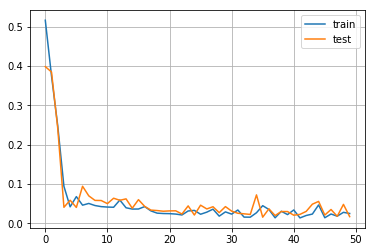

<type 'dict'>
['loss', 'val_loss']


In [598]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid()
plt.legend()
plt.show()


print type(history.history)
print history.history.keys()

In [599]:
loss = model.evaluate(test_X, test_y)

print loss

10483/10483 [==============================] - 0s 28us/step
0.01695512451


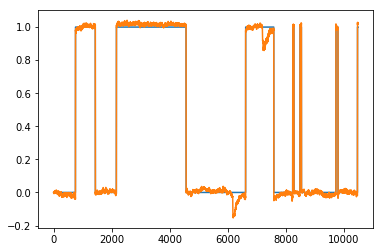

In [605]:
pred = model.predict(test_X)

plt.plot(test_y)
plt.plot(pred)

In [604]:
# make a prediction
yhat = model.predict_classes(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

expected = test_y.astype(int)
measured = yhat.reshape((len(yhat),))

print expected
print measured

# calculate RMSE
rmse = mt.sqrt(SklMetrics.mean_squared_error(expected, measured))
print('Test RMSE: %.3f' % rmse)



[0 0 0 ..., 1 1 1]
[0 0 0 ..., 1 1 1]
Test RMSE: 0.035


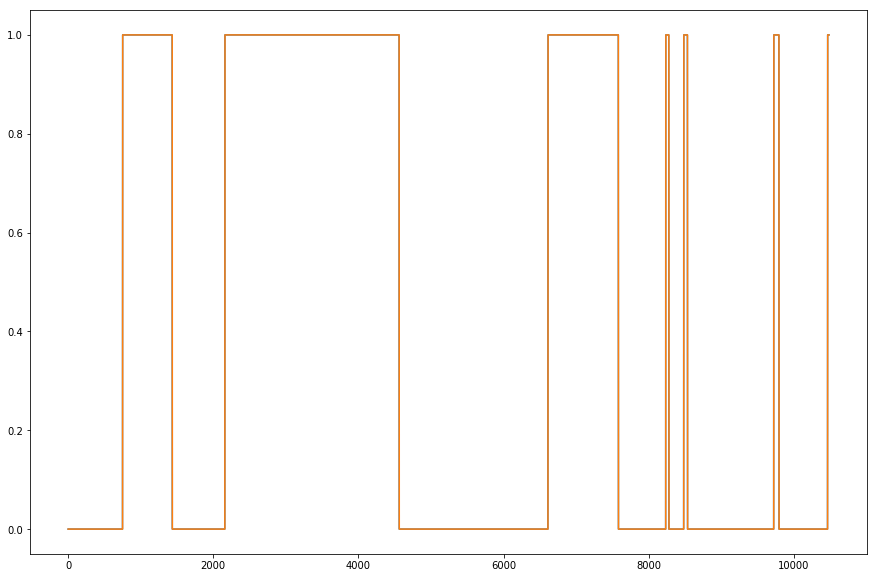

In [601]:
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(10)
plt.plot(expected)
plt.plot(measured)


In [593]:
res = np.where(expected != measured)



print res[0]
print res[0].shape

[  750  1434  2159  4560  6610  7580  8232  8275  8480  8532  9720  9792
 10462]
(13,)
